## Data Path Preparation
Run code cells by 'cmd + return'</br>
Code cells must run in sequence

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# %cd /content/drive/Shareddrives/SeniorDesignGroup/Colab_Files/Repositories/Unet_2D_EM_Segmentation
%cd /content/drive/Shareddrives/SeniorDesignGroup/Training_Data_GBM/

/content/drive/Shareddrives/SeniorDesignGroup/Training_Data_GBM


In [3]:
import os
import sys
import glob
import numpy as np
import tensorflow as tf
import skimage.io as io
import skimage.transform as trans

In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from __future__ import print_function

## Data Augmentation

### Data Augmentation Util Functions

In [5]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, 
                       Fence, Car, Pedestrian, Bicyclist, Unlabelled])

In [44]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

### Start Data Augmentation

In [7]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'','image','label',data_gen_args,save_to_dir = "aug")

In [8]:
# 60 transformed images and their masks will be stored in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.


In [ ]:
image_arr,mask_arr = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#np.save("data/image_arr.npy",image_arr)
#np.save("data/mask_arr.npy",mask_arr)

## Implement Training Model
Use Keras to generate U-Net

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    Adam = tf.keras.optimizers.Adam(lr = 1e-4)
    model.compile(optimizer = Adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [11]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(2,'','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Epoch 1/5
2000/2000 [==============================] - 229s 105ms/step - loss: 0.1432 - accuracy: 0.9501

Epoch 00001: loss improved from inf to 0.14315, saving model to unet_membrane.hdf5
Epoch 2/5
2000/2000 [==============================] - 176s 88ms/step - loss: 0.0629 - accuracy: 0.9810

Epoch 00002: loss improved from 0.14315 to 0.06285, saving model to unet_membrane.hdf5
Epoch 3/5
2000/2000 [==============================] - 176s 88ms/step - loss: 0.0503 - accuracy: 0.9865

Epoch 00003: loss improved from 0.06285 to 0.05033, saving model to unet_membrane.hdf5
Epoch 4/5
2000/2000 [==============================] - 176s 88ms/step - loss: 0.0438 - accuracy: 0.9892

Epoch 00004: loss improved from 0.05033 to 0.04375, saving model to unet_membrane.hdf5
Epoch 5/5
2000/2000 [==============================] - 176s 88ms/step - loss: 0.0388 - accuracy: 0.9907

Epoch 00005: loss improved from 0.04375 to 0.038

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [14]:
test_num = 40
testGene = testGenerator("test",num_image = test_num)
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,test_num,verbose=1)
saveResult("test_pred",results)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


40/40 [==============================] - 17s 412ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/0_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/1_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/2_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/3_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/4_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/5_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/6_predict.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: test_pred/7_predict.png is a low contras

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


30/30 [==============================] - 8s 258ms/step


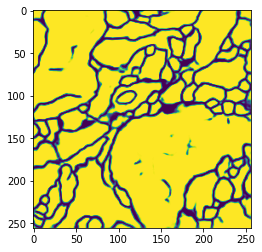

In [43]:
!cd /content/drive/Shareddrives/SeniorDesignGroup/Colab_Files/Repositories/Unet_2D_EM_Segmentation/
test_num = 30
testGene = testGenerator("data/membrane/test",num_image=test_num)
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,test_num,verbose=1)
saveResult("data/membrane/test_pred",results)